In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Fit Stan Models

In [2]:
import os, sys, pystan
import numpy as np
from pandas import read_csv
from notorious.io import load_model, save_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'pit_m3_np'

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and preprocess data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Reject participants.
reject = read_csv(os.path.join('data','reject.csv'))
data = data.merge(reject[['Subject','Reject']]).query('Reject==False')

## Restrict only to v0.3.
data = data.query(f'Version==3')
    
## Reformat columns.
data['Robot'] = data.Robot.replace({'GW':0, 'NGW':1, 'GAL':2, 'NGAL':3})
data['Outcome'] = data['Outcome'].replace({10:1, 1:0, -10:-1, -1:0})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble data for Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define data.
R = data.pivot_table('Outcome',('Subject','Robot'),'Exposure').values.T
Y = data.pivot_table('Choice',('Subject','Robot'),'Exposure').values.T

## Define mappings.
pivot = data.pivot_table('Choice',('Subject','Robot'),'Exposure')
sub_ix = np.unique(pivot.index.get_level_values(0), return_inverse=True)[-1] + 1
pav_ix = np.where(pivot.index.get_level_values(1) < 2, 1, -1)

## Define metadata.
T, H = Y.shape

## Assemble data.
dd = dict(H=H, T=T, Y=Y, R=R, sub_ix=sub_ix, pav_ix=pav_ix)

## Section 2: Model Comparison

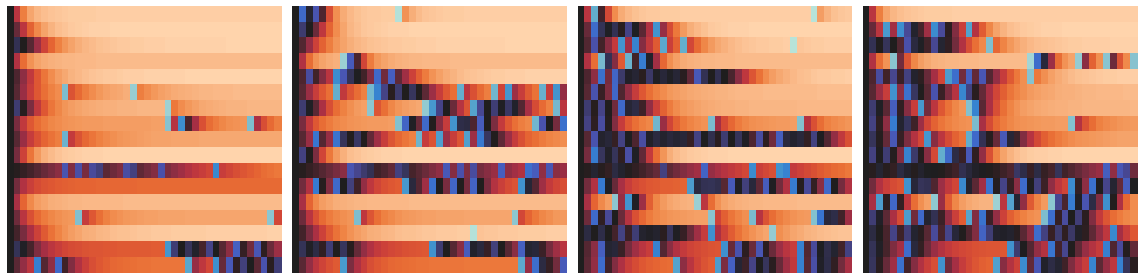

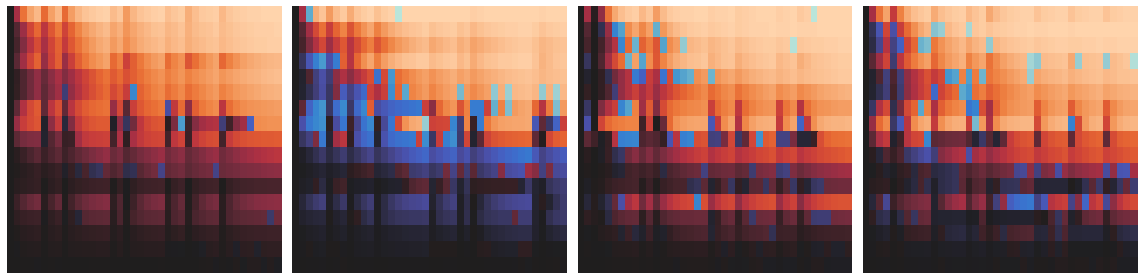

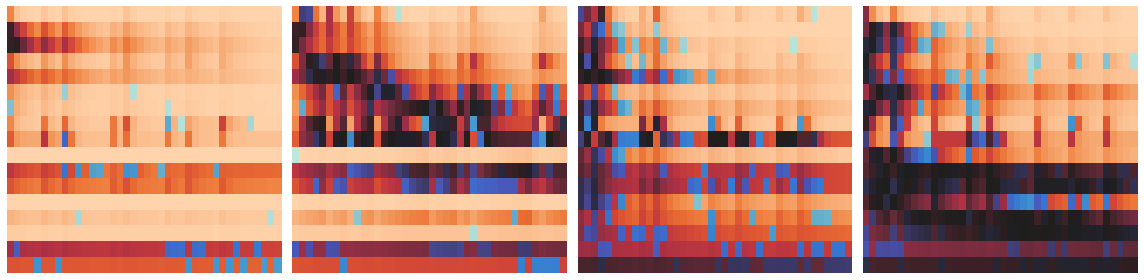

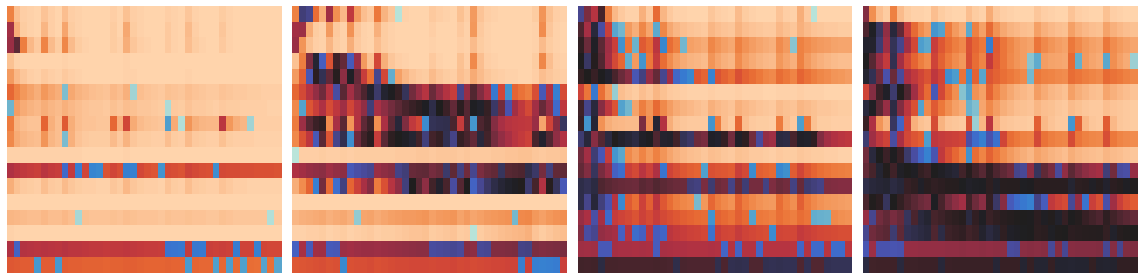

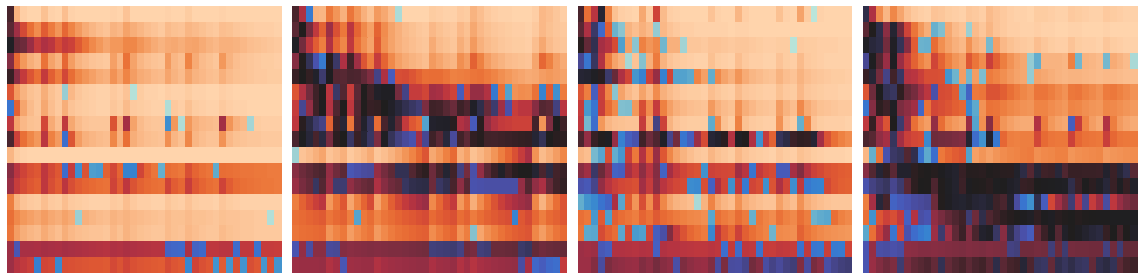

In [3]:
from notorious.io import load_fit
from notorious.posterior import posterior_predictive_pit
from notorious.posterior import posterior_predictive_ck
from notorious.posterior import waic

## Define models.
models = ['ck_m1_np', 'pit_m0_np', 'pit_m1_np', 'pit_m2_np', 'pit_m3_np']

sort_ix = data.groupby('Subject').Accuracy.mean().argsort()[::-1]

## Main loop.
WAIC = []
for m in models:

    samples = load_fit(f'stan_results/{m}.pkl')
    if 'pit' in m:
        log_lik, y_pred = posterior_predictive_pit(samples, simulate=True)
    else:
        log_lik, y_pred = posterior_predictive_ck(samples, simulate=True)
        
    ## Compute WAIC.
    WAIC.append(waic(log_lik))
    
    fig, axes = plt.subplots(1,4,figsize=(16,4))

    for i, ax in enumerate(axes):

        ## Visualize likelihood.
        arr = np.median(np.exp(log_lik), axis=0)
        arr = arr[:,i::4].T
        
        ## Visualize average predictive accuracy.
        # arr = (samples['Y'] == y_pred).mean(axis=0)
        # arr = arr[:,i::4].T

        sns.heatmap(arr[sort_ix], vmin=0, vmax=1, center=0.5, cbar=False, 
                    xticklabels=[], yticklabels=[], ax=ax)

    plt.tight_layout()

<BarContainer object of 5 artists>

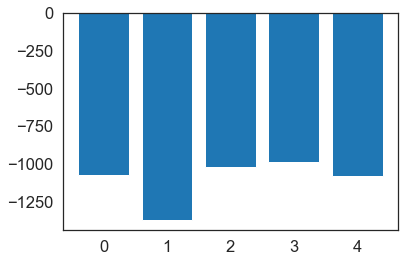

In [4]:
WAIC = np.array(WAIC)
plt.bar([0,1,2,3,4],WAIC.sum(axis=1).sum(axis=1))

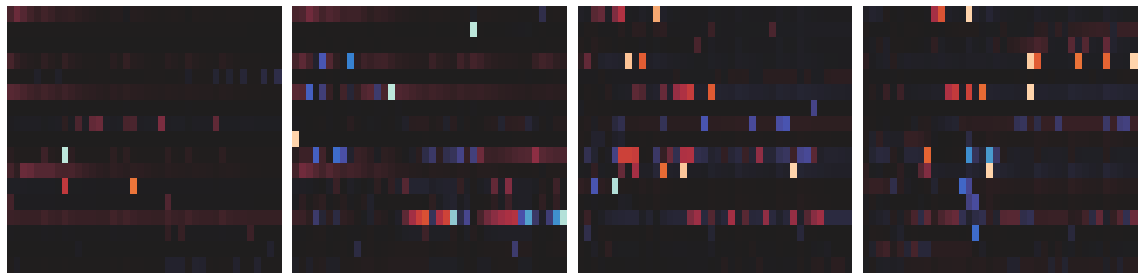

In [5]:
fig, axes = plt.subplots(1,4,figsize=(16,4))

for i, ax in enumerate(axes):

    ## Define likelihood.
    arr = WAIC[3] - WAIC[2]
    arr = arr[:,i::4].T

    sns.heatmap(arr, vmin=-1, vmax=1, center=0, cbar=False, 
                xticklabels=[], yticklabels=[], ax=ax)

plt.tight_layout()

## Section 3: Correlations

In [6]:
## Load model fit.
samples = load_fit(f'stan_results/pit_m1_np.pkl')

## Compute groupby.
gb = data.groupby(['Subject','Robot']).Accuracy.mean().reset_index()
gb = gb.pivot_table('Accuracy','Subject','Robot')
gb.columns = ['GW','NGW','GAL','NGAL']

### Behavior-Behavior Correlations

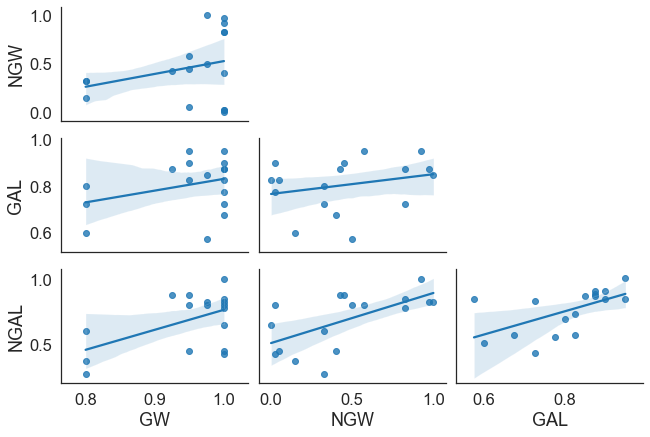

In [7]:
## Initialize canvas.
fig = plt.figure(figsize=(12,8))

for i in np.arange(0,3):
    
    for j in np.arange(i+1,4):
        
        ## Initialize subplot.
        ax = plt.subplot2grid((4,4),(j,i))
        
        ## Plot.
        sns.regplot(gb[gb.columns[i]], gb[gb.columns[j]], ax=ax)
        
        ## Add details.
        if j < 3: ax.set(xticks=[], xlabel='')
        if i: ax.set(yticks=[], ylabel='')
            
sns.despine()
plt.tight_layout()

### Behavior-Parameter Correlations

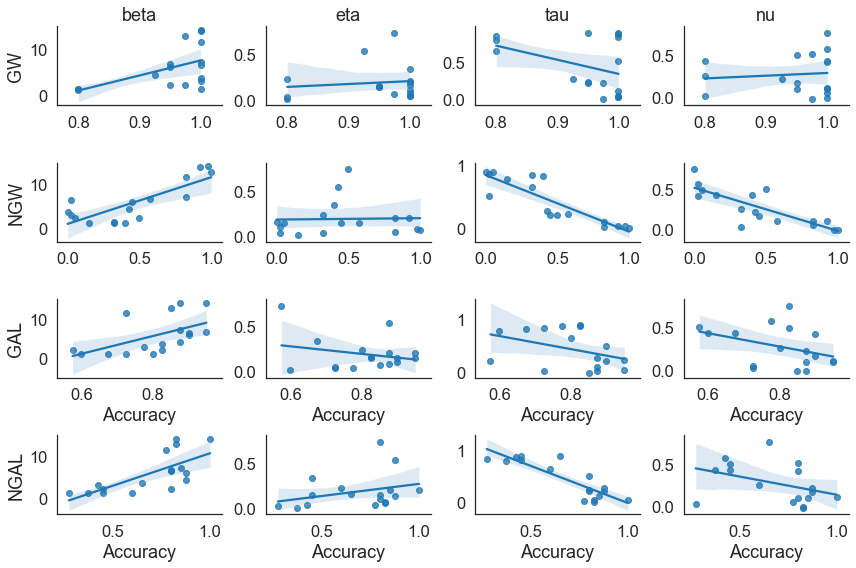

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(4,4,figsize=(12,8))

## Iteratively plot.
for i, robot in enumerate(['GW','NGW','GAL','NGAL']):

    for j, par in enumerate(['beta','eta','tau','nu']):
    
        ## Extract paramter.
        arr = np.median(samples[par], axis=0)
        
        ## Plot.
        sns.regplot(gb[robot], arr, ax=axes[i,j])
        
        ## Add details.
        if not i: axes[i,j].set_title(par)
        if not j: axes[i,j].set_ylabel(robot)
        if i < 2: axes[i,j].set_xlabel('')
        else: axes[i,j].set_xlabel('Accuracy')
            
sns.despine()
plt.tight_layout()

### Parameter Range

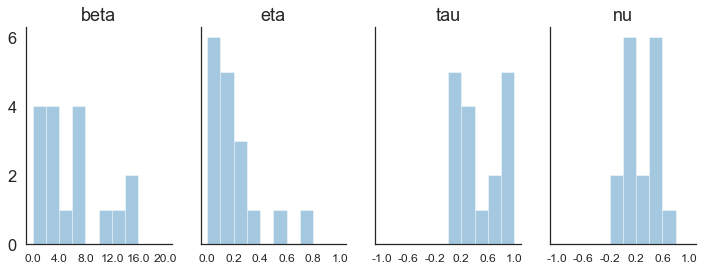

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,4),sharey=True)
lims = [(0,20),(0,1),(-1,1),(-1,1)]

for ax, par, lim in zip(axes, ['beta','eta','tau','nu'], lims):

    ## Extract paramter.
    arr = np.median(samples[par], axis=0)
        
    ## Plot.
    bins = bins=np.linspace(*lim, 11)
    sns.distplot(arr, bins, kde=False, ax=ax)
    ax.set(xticks=bins[::2], title=par)
    ax.set_xticklabels(bins[::2].round(1), fontsize=12)
    
sns.despine()